In [1]:
import numpy as np
import pandas as pd

In [2]:
train_df = pd.read_csv('../train.csv',index_col="tripid")

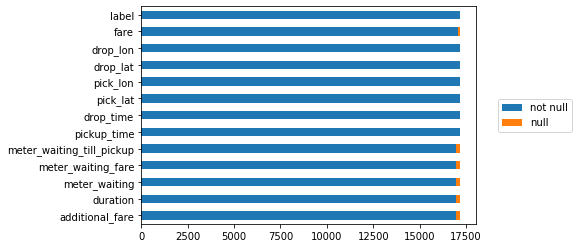

In [3]:
ax = pd.DataFrame({'not null': train_df.count(),
                   'null': train_df.isnull().sum()}).plot.barh(stacked=True)

ax.legend(
    loc='center left', 
    bbox_to_anchor=(1.05, 0.5)
)

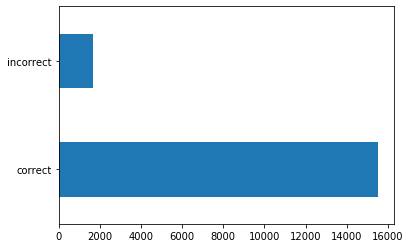

In [4]:
train_df['label'].value_counts().plot.barh()

In [5]:
from sklearn.preprocessing import label_binarize
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler

RANDOM_SEED = 42  

In [6]:
labels_raw_df = train_df.loc[:, train_df.columns == 'label']
features_raw_df = train_df.drop(columns=['label'])

In [7]:
def preprocess_labels(input_labels_df):
  labels_df = input_labels_df
  labels_df = pd.DataFrame(label_binarize(labels_df, classes=['incorrrect', 'correct']))
  
  labels_df.columns = labels_df.columns
  labels_df.index = labels_df.index

  return labels_df  

In [8]:
labels_df = preprocess_labels(labels_raw_df)

In [9]:
def preprocess_features(input_features_df):
  features_df = input_features_df.copy()
  numeric_cols = features_df.columns[features_df.dtypes != "object"].values 
  non_numeric_cols = features_df.columns[features_df.dtypes == "object"].values

  #numeric
  #scale features
  scaler = RobustScaler()
  features_df[numeric_cols] = scaler.fit_transform(features_df[numeric_cols])

  #impute missing values
  imputer = KNNImputer()
  features_df[numeric_cols] = imputer.fit_transform(features_df[numeric_cols])

  #date time
  features_df['pickup_time'] = pd.to_datetime(features_df['pickup_time'])
  features_df['drop_time'] = pd.to_datetime(features_df['drop_time'])
  
  #get day of the week
  features_df['pickup_day_of_week'] = features_df['pickup_time'].dt.day_name()
  features_df['drop_day_of_week'] = features_df['drop_time'].dt.day_name()
  
  features_df['pickup_hour_float'] = features_df['pickup_time'].dt.hour + features_df['pickup_time'].dt.minute/60
  features_df['drop_hour_float'] = features_df['drop_time'].dt.hour + features_df['drop_time'].dt.minute/60

  #encode cyclic 24 hours with sin and cos
  features_df['sin_pickup_time'] = np.sin(2*np.pi*features_df.pickup_hour_float/24.)
  features_df['cos_pickup_time'] = np.cos(2*np.pi*features_df.pickup_hour_float/24.)

  features_df['sin_drop_time'] = np.sin(2*np.pi*features_df.drop_hour_float/24.)
  features_df['cos_drop_time'] = np.cos(2*np.pi*features_df.drop_hour_float/24.)

  #get weekday or weekend
  weekenddays = ['Saturday', 'Sunday']

  features_df['pickup_weekday'] = np.where(features_df['pickup_day_of_week'].isin(weekenddays), 0, 1)
  features_df['drop_weekday'] = np.where(features_df['drop_day_of_week'].isin(weekenddays), 0, 1)
  
  features_df = pd.get_dummies(features_df, columns = ['pickup_day_of_week', 'drop_day_of_week'])
  
  features_df = features_df.drop(columns=['pickup_time','drop_time'])
  
  return features_df

In [10]:
features_df = preprocess_features(features_raw_df)

In [85]:
test_features_raw_df = pd.read_csv('../test.csv',index_col="tripid")
test_features_df = preprocess_features(test_features_raw_df)

In [12]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score, confusion_matrix

from sklearn.model_selection import train_test_split, cross_val_score

from bayes_opt import BayesianOptimization

RANDOM_SEED = 4
thresh = 5

In [13]:
#Bayesian optimization
def bayesian_optimization(dataset, function, parameters):
   x_train, y_train, x_eval, y_eval = dataset
   n_iterations = 5
   gp_params = {"alpha": 1e-4}

   BO = BayesianOptimization(function, parameters)
   BO.maximize(n_iter=n_iterations, **gp_params)

   return BO.max

In [14]:
def rfc_optimization(cv_splits):
    def function(n_estimators, max_depth, min_samples_split):
        return cross_val_score(
               RandomForestClassifier(
                   n_estimators=int(max(n_estimators,0)),                                                               
                   max_depth=int(max(max_depth,1)),
                   min_samples_split=int(max(min_samples_split,2)), 
                   n_jobs=-1, 
                   random_state=RANDOM_SEED,   
                   class_weight="balanced"),  
               X=x_train, 
               y=y_train, 
               cv=cv_splits,
               scoring="f1",
               n_jobs=-1).mean()

    parameters = {"n_estimators": (30, 500),
                  "max_depth": (100, 250),
                  "min_samples_split": (2, 7)}
    
    return function, parameters

In [15]:
def train(x_train, y_train, x_eval, y_eval, function, parameters):
    dataset = (x_train, y_train, x_eval, y_eval )
    cv_splits = 4
    
    best_solution = bayesian_optimization(dataset, function, parameters)      
    params = best_solution["params"]

    model = RandomForestClassifier(
             n_estimators=int(max(params["n_estimators"], 0)),
             max_depth=int(max(params["max_depth"], 1)),
             min_samples_split=int(max(params["min_samples_split"], 2)), 
             n_jobs=-1, 
             random_state=42,   
             class_weight="balanced")

    model.fit(x_train, y_train)
    
    return model

In [16]:
function, parameters = rfc_optimization(3)

In [17]:
x_train, x_eval, y_train, y_eval = train_test_split(
    features_df,
    labels_df,
    test_size=0.2,
    shuffle=True,
    stratify=labels_df,
    random_state=RANDOM_SEED
)

In [18]:
model = train(x_train, y_train.values.ravel(), x_eval, y_eval.values.ravel(), function, parameters)

|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
|  1        |  0.9593   |  191.2    |  5.131    |  146.3    |
|  2        |  0.9584   |  174.7    |  4.213    |  491.5    |
|  3        |  0.9579   |  109.9    |  3.622    |  47.28    |
|  4        |  0.9575   |  201.3    |  2.183    |  84.0     |
|  5        |  0.9592   |  122.1    |  4.326    |  36.93    |
|  6        |  0.9591   |  247.5    |  5.233    |  499.5    |
|  7        |  0.9583   |  101.7    |  4.55     |  500.0    |
|  8        |  0.9579   |  247.1    |  2.739    |  499.2    |
|  9        |  0.9592   |  248.9    |  5.558    |  34.36    |
|  10       |  0.958    |  103.2    |  3.829    |  498.4    |


In [19]:
model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=191, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=146,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [20]:
y_pred = model.predict(x_eval)

In [21]:
print('F1 score: {:.6f}'.format(f1_score(y_eval, y_pred)))
print('F1 score: {:.6f}'.format(f1_score(y_eval, y_pred, average='macro')))

F1 score: 0.959301
F1 score: 0.695337


In [22]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
train_results = []
test_results = []
for estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators=estimator, bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                           criterion='gini', max_depth=149, max_features='auto',
                           max_leaf_nodes=None, max_samples=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=7,
                           min_weight_fraction_leaf=0.0,
                           n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                           warm_start=False)
    rf.fit(x_train, y_train.values.ravel())
    train_pred = rf.predict(x_train)
    f1 = f1_score(train_pred, y_train)
    train_results.append(f1)
    y_pred = rf.predict(x_eval)
    f1 = f1_score(y_pred, y_eval)
    test_results.append(f1)

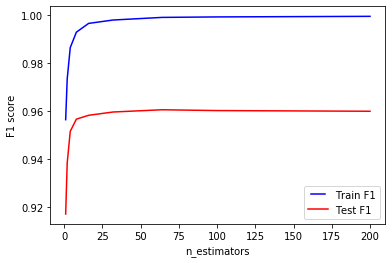

Max F1 Score at >  7  :   0.9605365777569802


In [23]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label='Train F1')
line2, = plt.plot(n_estimators, test_results, 'r', label='Test F1')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('F1 score')
plt.xlabel('n_estimators')
plt.show()

import operator
max_index, max_value = max(enumerate(test_results), key=operator.itemgetter(1))
print("Max F1 Score at > ",max_index+1, " :  ", max_value)

In [24]:
max_depths = np.linspace(1, 240, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
    rf = RandomForestClassifier(n_estimators=25, bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                           criterion='gini', max_depth=max_depth, max_features='auto',
                           max_leaf_nodes=None, max_samples=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=7,
                           min_weight_fraction_leaf=0.0,
                           n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                           warm_start=False)
    rf.fit(x_train, y_train.values.ravel())
    train_pred = rf.predict(x_train)
    f1 = f1_score(train_pred, y_train)
    train_results.append(f1)
    y_pred = rf.predict(x_eval)
    f1 = f1_score(y_pred, y_eval)
    test_results.append(f1)

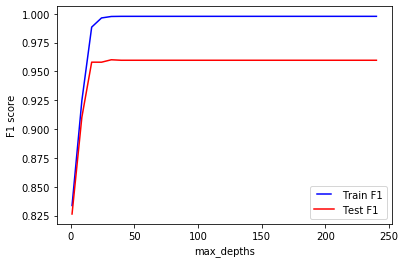

Max F1 Score at >  5  :   0.9601375644833516


In [25]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label='Train F1')
line2, = plt.plot(max_depths, test_results, 'r', label='Test F1')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('F1 score')
plt.xlabel('max_depths')
plt.show()

import operator
max_index, max_value = max(enumerate(test_results), key=operator.itemgetter(1))
print("Max F1 Score at > ",max_index+1, " :  ", max_value)

In [26]:
min_samples_splits = np.linspace(2, 30, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
    rf = RandomForestClassifier(n_estimators=25, bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                           criterion='gini', max_depth=50, max_features='auto',
                           max_leaf_nodes=None, max_samples=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=int(min_samples_split),
                           min_weight_fraction_leaf=0.0,
                           n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                           warm_start=False)
    rf.fit(x_train, y_train.values.ravel())
    train_pred = rf.predict(x_train)
    f1 = f1_score(train_pred, y_train)
    train_results.append(f1)
    y_pred = rf.predict(x_eval)
    f1 = f1_score(y_pred, y_eval)
    test_results.append(f1)

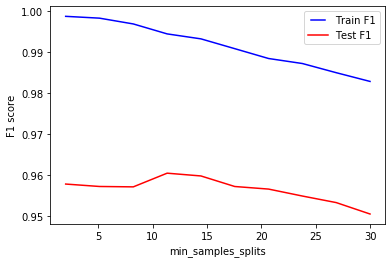

Max F1 Score at >  4  :   0.9605386783589102


In [27]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, 'b', label='Train F1')
line2, = plt.plot(min_samples_splits, test_results, 'r', label='Test F1')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('F1 score')
plt.xlabel('min_samples_splits')
plt.show()

import operator
max_index, max_value = max(enumerate(test_results), key=operator.itemgetter(1))
print("Max F1 Score at > ",max_index+1, " :  ", max_value)

In [28]:
min_samples_leafs = np.linspace(1, 10, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
    rf = RandomForestClassifier(n_estimators=25, bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                           criterion='gini', max_depth=50, max_features='auto',
                           max_leaf_nodes=None, max_samples=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=int(min_samples_leaf), min_samples_split=11,
                           min_weight_fraction_leaf=0.0,
                           n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                           warm_start=False)
    rf.fit(x_train, y_train.values.ravel())
    train_pred = rf.predict(x_train)
    f1 = f1_score(train_pred, y_train)
    train_results.append(f1)
    y_pred = rf.predict(x_eval)
    f1 = f1_score(y_pred, y_eval)
    test_results.append(f1)

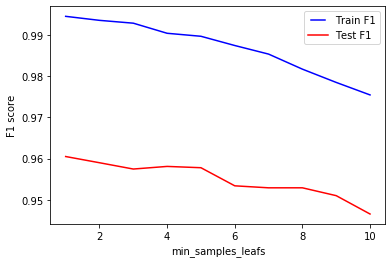

Max F1 Score at >  1  :   0.9605386783589102


In [29]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leafs, train_results, 'b', label='Train F1')
line2, = plt.plot(min_samples_leafs, test_results, 'r', label='Test F1')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('F1 score')
plt.xlabel('min_samples_leafs')
plt.show()

import operator
max_index, max_value = max(enumerate(test_results), key=operator.itemgetter(1))
print("Max F1 Score at > ",max_index+1, " :  ", max_value)

In [64]:
max_features = list(range(1,x_train.shape[1]))
train_results = []
test_results = []

for max_feature in max_features:
    rf = RandomForestClassifier(n_estimators=25, bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                           criterion='gini', max_depth=50, max_features=max_feature,
                           max_leaf_nodes=None, max_samples=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=2, min_samples_split=11,
                           min_weight_fraction_leaf=0.0,
                           n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                           warm_start=False)
    rf.fit(x_train, y_train.values.ravel())
    train_pred = rf.predict(x_train)
    f1 = f1_score(train_pred, y_train)
    train_results.append(f1)
    y_pred = rf.predict(x_eval)
    f1 = f1_score(y_pred, y_eval)
    test_results.append(f1)

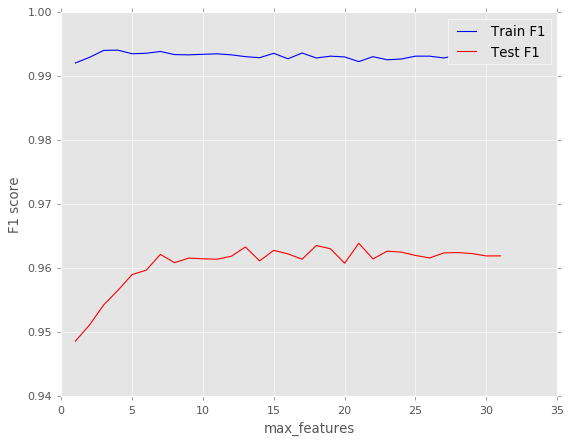

Max F1 Score at >  21  :   0.9639281741617671


In [84]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_features, train_results, 'b', label='Train F1')
line2, = plt.plot(max_features, test_results, 'r', label='Test F1')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('F1 score')
plt.xlabel('max_features')
plt.show()

import operator
max_index, max_value = max(enumerate(test_results), key=operator.itemgetter(1))
print("Max F1 Score at > ",max_index+1, " :  ", max_value)

In [72]:
rf = RandomForestClassifier(n_estimators=25, bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                           criterion='gini', max_depth=50, max_features=21,
                           max_leaf_nodes=None, max_samples=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=2, min_samples_split=11,
                           min_weight_fraction_leaf=0.0,
                           n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                           warm_start=False)

rf.fit(x_train, y_train.values.ravel())

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=50, max_features=21,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=11,
                       min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [73]:
y_pred = rf.predict(x_eval)
y_pred

array([1, 1, 1, ..., 1, 0, 1])

In [74]:
print(f'F1 score: {f1_score(y_eval, y_pred)}')
print(f'F1 score: {f1_score(y_eval, y_pred, average="macro")}')

F1 score: 0.9639281741617671
F1 score: 0.7859364532294155


In [76]:
feature_list = list(features_df.columns)
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: duration             Importance: 0.26
Variable: fare                 Importance: 0.24
Variable: meter_waiting        Importance: 0.07
Variable: additional_fare      Importance: 0.06
Variable: meter_waiting_till_pickup Importance: 0.05
Variable: meter_waiting_fare   Importance: 0.04
Variable: pick_lon             Importance: 0.04
Variable: pick_lat             Importance: 0.03
Variable: drop_lat             Importance: 0.03
Variable: drop_lon             Importance: 0.03
Variable: cos_pickup_time      Importance: 0.03
Variable: pickup_hour_float    Importance: 0.02
Variable: drop_hour_float      Importance: 0.02
Variable: sin_pickup_time      Importance: 0.02
Variable: sin_drop_time        Importance: 0.02
Variable: cos_drop_time        Importance: 0.02
Variable: pickup_weekday       Importance: 0.0
Variable: drop_weekday         Importance: 0.0
Variable: pickup_day_of_week_Friday Importance: 0.0
Variable: pickup_day_of_week_Monday Importance: 0.0
Variable: pickup_day_of_week_

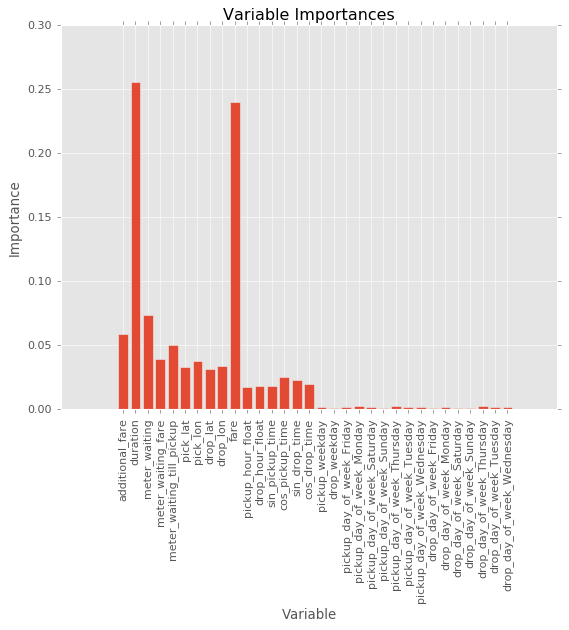

In [83]:
# Set the style
plt.style.use('ggplot')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');
